# Modelling Koala Populations using a Predator Prey Model (Non-spatial)
The Koala population, once found in abundance, have been declared as 'endangered' as a result of factors such as  widespread bushfires, drought and land-clearing, which have destroyed their natural eucalyptus-rich habitat. To observe the koala population in their natural eucalyptus habitat - without influence of such factors - a predator prey model will be used. This will be achieved using through an Agent Based Model (ABM) in Julia. 

In [12]:
#dependencies of the model
using Agents, Random
using InteractiveDynamics
using CairoMakie
using Plots
using Statistics
using Distributions

# If needed, the packages can be installed through using the command:
#import Pkg; Pkg.add("StatsPlots")

# ABM using Agents.jl

For the ABM, the Agents.jl framework within Julia can be utilised. As per this framework, an agent type must be created intially. Here, we create a general agent type called KoalaOrEucalyptus. This agent type, as the name suggests, will be used for both the predator (Koala) and prey (Eucalyptus) agents. The agent has the following properties:

    id - id within the model (required)
    type - type of Agent so either Koala or Eucalyptus 
    death_prob - The death probability only for Koala agents 
    production_rate - The birth/production rate for only Eucalyptus agents
    consume_rate - The death/consumption rate for only Eucalyptus agents

In [13]:
mutable struct KoalaOrEucalyptus <: AbstractAgent
    id::Int
    type::Symbol #:koala or :Eucalyptus
    death_prob::Float64 #only for Koala
    production_rate::Float64 #only for eucalyptus
    consume_rate::Float64 #only for eucalyptus
end

To enable faster creation of the two Agent types, the two following helper functions can be used:

In [14]:
#helper functions used to more conveniently create koala or eucalyptus agents
Koala(id,death_prob,production_rate, consume_rate) = KoalaOrEucalyptus(id, :koala, death_prob, production_rate, consume_rate)
Eucalyptus(id,death_prob,production_rate, consume_rate) = KoalaOrEucalyptus(id, :eucalyptus, death_prob, production_rate, consume_rate)

Eucalyptus (generic function with 1 method)

## Creating the initial model
To initalise and create the initial ABM, a helper function (initalize_model) can be defined. The parameters for this function are as follow:

    n_koala - Initial koala population 
    n_eucalyptus - Initial eucalyptus population 
    input_params - as a array containing the following (in order):
        koala_death_rate #death rate of koalas 
        eucalyptus_production_rate #birth/production rate of eucalyptus
        eucalyptus_consume_rate #death/consumption rate of eucalyptus 
        
These parameters can then be mapped to be properties of the model such that they can be accessed by syntax such as model.koala_death_rate or model.eucalyptus_production_rate. 

To create the model, the ABM() from the Agents.jl framework can be used. This function accepts the type of agent (KoalaOrEucalyptus), the model properties, the rng and the default scheduler (Shedulers.randomly). To populate the ABM, we can loop through the required population amounts(n_koala and n_eucalyptis) and create the appropriate Agent type which can then be added to the model using add_agent!. 


In [15]:
#Initialises the overall ABM, and populates the ABM with the required amount of koala and eucalyptus agents
function initialize_model(;
    #parameters that can be inputted into model e.g model = initalise_model(n_koalas = 30)
    n_koala = 10, #number of initial koalas
    n_eucalyptus = 20, #number of initial eucalyptus
    input_params:: Vector{Float64}, #Input paramaters as a vector 
    seed = 23182, #rng seed 
     )
     koala_death_rate = input_params[1] #death rate of koala agents
     eucalyptus_production_rate = input_params[2]#production rate of eucalyptus
     eucalyptus_consume_rate = input_params[3] #death/consumption rate of eucalyptus
     #create model properties
     properties = Dict(:euca_pr => eucalyptus_production_rate, :koala_dr => koala_death_rate, :euca_cr => eucalyptus_consume_rate)

     rng = MersenneTwister(seed) #seed the rng
     #create the ABM with the agent type, properties and rng
     model = ABM(KoalaOrEucalyptus; properties,rng, scheduler = Schedulers.randomly)

     id = 0; #starting index of agent ids

     #populate ABM with n_koalas 
     for _ in 1:n_koala
         id += 1
         koala = Koala(id, koala_death_rate, 0,0) #create koala agent  - 0, 0 for production and consumption rate
         add_agent!(koala, model) #add agent to simulation
     end

     #populate ABM with n_eucalyptus 
     for _ in 1:n_eucalyptus
         id += 1
         eucalyptus = Eucalyptus(id, 0, eucalyptus_production_rate, eucalyptus_consume_rate) #create Eucalyptus agent - 0 for death_prob
         add_agent!(eucalyptus, model)  #add agent to simulation
     end

     return model
 end


initialize_model (generic function with 1 method)

### Helper functions to count number of koalas and eucalyptus agents
The two following helper functions, which return the current koala and eucalyptus agents in model m, can also be defined:

In [16]:
#helper functions to count amount koala and eucalyptus agents
leaf(m) = count(a.type == :eucalyptus for a in allagents(m)) #for eucalyptus agents
koalas(m) = count(a.type == :koala for a in allagents(m)) #for koala agents

koalas (generic function with 1 method)

## Agent step function
The next step in creating an ABM is to create an agent step function that will define how all individual agents will evolve over time. As there are two different agents, we check the agent type being evolved (passed in as a parameter agent) and then call the respective agent_step function (either koala_step or eucalytpus_step). 

Additionally, through trial and error, it was determined that to observe predator-prey dynamics within the model, an assumption that if either the koala or eucalyptus population drops to 0, an additional agent of that type must be introduced to the model was made. This assumption is reasonable as in real-life senarios, more koalas may begin to inhabit an area due to low populations or that more eucalyptus would grow as the population drops. 

In [17]:
 #Agent step function that governs evolution of agents over one time step
 function agent_step!(agent::KoalaOrEucalyptus,model)
    #determine agent type and call respective step function 
     if agent.type == :koala 
         koala_step!(agent,model)
    else
        eucalyptus_step!(agent,model)
    end

    #determine the current number of koalas and eucalyptus
    num_euca = leaf(model)
    num_koalas = koalas(model)

    #if there are no eucalyptus agents within the simulation, 
    #then based on the eucalyptus production rate, add a eucalyptus agent to simulation
    if num_euca == 0
        if rand() < model.euca_pr
            id = nextid(model)
            eucalyptus_new = Eucalyptus(id, 0,  model.euca_pr, model.euca_cr)
            add_agent!(eucalyptus_new, model)
        end
    end

    #if there are no koala agents in simulation, then
    #based on the eucalyptus consumption rate, add a koala agent to simulation
    if num_koalas == 0
        if rand() < model.euca_cr
            id = nextid(model)
            koala_new = Koala(id, model.koala_dr, 0,0)
            add_agent!(koala_new, model)
        end
    end


 end

agent_step! (generic function with 1 method)

### Koala step 
For the koala agents, there are two possible events - either birth (through eating) or death. To allow for only one of these events in a single time step, we can utilise the koala_death_prob to determine which event occurs and then call the respective helper function (kill_agent is a built in function within Agents.jl). 

In [18]:
 #Describes the two possible events for koala agents - birth or death - within a single time step
 function koala_step!(koala,model)
    #To allow for single event within a single time step,
    #the possible event is determined based if rand() < koala_death_prob
     if rand() < koala.death_prob
         kill_agent!(koala,model)
     else
        koala_eat!(koala,model)
     end

 end

koala_step! (generic function with 1 method)

### Koala Birth Event
The koala birth event is governed through the koala consuming an eucalyptus (so a death event for the eucalyptus) which results an another koala or a birth event. This is done through selecting a random agent from within the simulation, and if the agent is of type :eucalyptus, killing the eucalyptus agent and then adding an additional koala agent. 

In [19]:
#Describes process of koala eating which leads to a birth event for koala agent and death event for eucalyptus
 function koala_eat!(koala, model)
     food = random_agent(model); #select a random agent from simulation
     if food.type == :eucalyptus #if random agent is eucalyptus
         if rand() < food.consume_rate
            #consume agent if above condition is met
             kill_agent!(food,model) 
             id = nextid(model)
             koala_new = Koala(id, model.koala_dr, 0,0) 
             add_agent!(koala_new, model) #add new koala to simulation
         end
     end
 end

koala_eat! (generic function with 1 method)

### Eucalyptus Step
Similar to the koala agents, eucalyptus agents also have a birth and death event. As the koala birth event already results in an eucalyptus death event, the eucalyptus_step only results in a birth event. The birth event is primarily determined by a value calculated by factoring both the eucalyptus production rate and the current number of eucalyptus within the model. This allows for restricted Eucalyptus growth (which is realistic as the population of eucalyptus in an area may be restricted by factors such as space). 

In [20]:
 #Describes the possible event of birth for eucalyptus agents within a single time step 
function eucalyptus_step!(eucalyptus,model)
    new_euca = leaf(model) #calculate current num of eucalyptus
    if rand() < eucalyptus.production_rate*(1-(new_euca)/1000)
                #new eucalyptus if the above condition is met
                id = nextid(model)
                eucalyptus_new = Eucalyptus(id, 0, model.euca_pr, model.euca_cr)
                add_agent!(eucalyptus_new, model)
    end
end

eucalyptus_step! (generic function with 1 method)

# Defining parameters of model
Through trial and error of different parameter sets, it was determined that the following parameter set resulted in the most viable predator prey dynamics for the koala ABM:

In [21]:
#helper functions to easily determine agent types 
koala(a) = a.type == :koala
eucalyptus(a) = a.type == :eucalyptus

 koala_death_rate = 0.0025 #death rate of koala agents
eucalyptus_production_rate = 0.008 #production rate of eucalyptus
eucalyptus_consume_rate = 0.02 #death/consumption rate of eucalyptus

0.02

# Running the ABM
To run the ABM, we first create the model using the parameters defined previously and define the data to be collected from both the agents and model. Here, we intend to collect the number of agents (or adata) of type koala and eucalyptus hence we use the helper functions (above) to track these. 

This adata data vector and the created model can then be passed into run! function. The total number of time steps (nsteps) is also passed in. The result, adf, consists of the count of the koala and eucalyptus populations over time. 

In [22]:
#vector of parameters
ABM_params = [koala_death_rate;eucalyptus_production_rate;eucalyptus_consume_rate]

#initialise model with ABM_params and run model
 model = initialize_model(input_params = ABM_params)
 n_steps = 2000
 adata = [(koala, count), (eucalyptus, count)]
 adf, _ = run!(model, agent_step!, dummystep, n_steps; adata)


(2001×3 DataFrame
  Row │ step   count_koala  count_eucalyptus 
      │ Int64  Int64        Int64            
──────┼──────────────────────────────────────
    1 │     0           10                20
    2 │     1           10                20
    3 │     2           11                19
    4 │     3           11                19
    5 │     4           13                17
    6 │     5           13                17
    7 │     6           13                17
    8 │     7           13                17
    9 │     8           13                17
   10 │     9           13                17
   11 │    10           13                17
  ⋮   │   ⋮         ⋮              ⋮
 1992 │  1991            8                 1
 1993 │  1992            8                 1
 1994 │  1993            8                 1
 1995 │  1994            8                 1
 1996 │  1995            8                 1
 1997 │  1996            8                 1
 1998 │  1997            8                

# Plotting results
The result of the ABM can then be plotted

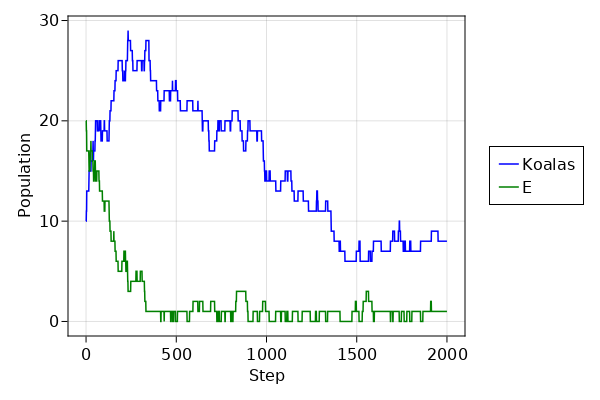

In [23]:
#helper function to plot results from one run
function plot_population_timeseries(adf)
     figure = Figure(resolution = (600, 400))
     ax = figure[1, 1] = Axis(figure; xlabel = "Step", ylabel = "Population")
     koalal = lines!(ax, adf.step, adf.count_koala, color = :blue)
     eucalyptusl = lines!(ax, adf.step, adf.count_eucalyptus, color = :green)
     figure[1, 2] = Legend(figure, [koalal, eucalyptusl], ["Koalas", "E"])
     figure
 end

 plot_population_timeseries(adf)

## Running the model multiple times
To assess the various dynamics that may result from the model, the model can be run multiple times. 

In [24]:
# initalise data vectors for results from the multiple runs with results from the first run
a_koalas = adf[:,2];
a_euca = adf[:,3];

#run model multiple times and append results to the above data vectors 
 for i in 2:100
     model_2 = initialize_model(input_params = ABM_params)
     n_step = 2000;
     agent_df_2, _ = run!(model_2, agent_step!, dummystep,n_step; adata);
     a_1 = agent_df_2[:,2];
     a_2 = agent_df_2[:,3];
     global a_koalas = [a_koalas a_1]
     global a_euca = [a_euca a_2]
 end

#all plots
 Plots.plot(adf.step, a_koalas[:,1],  label = "", title = "ABM populations from 100 runs",xlab="Time step",ylabel="Population", linecolor = :red, titlefontsize = 10)
 Plots.plot!(adf.step, a_euca[:,1], label = "",xlab="Time step",ylabel="Population", linecolor = :blue)
 for i in 2:(size(a_koalas)[2]-1)
     #Plots.plot!(t, a_50[:,i])#, seriestype = :scatter)
     Plots.plot!(adf.step, a_koalas[:,i], linecolor = :red, label = "")
     Plots.plot!(adf.step, a_euca[:,i], linecolor = :blue, label = "")

 end
 #Plots.plot!(t,a_50[:,50])#, seriestype = :scatter)
 Plots.plot!(adf.step, a_koalas[:,size(a_koalas)[2]], label = "Koala", linecolor = :red)
 Plots.plot!(adf.step, a_euca[:,size(a_koalas)[2]],label = "Eucalyptus", linecolor = :blue, legend = :topleft, legendfontsize = 6)


The general overall dynamic from the above run can also be observed:

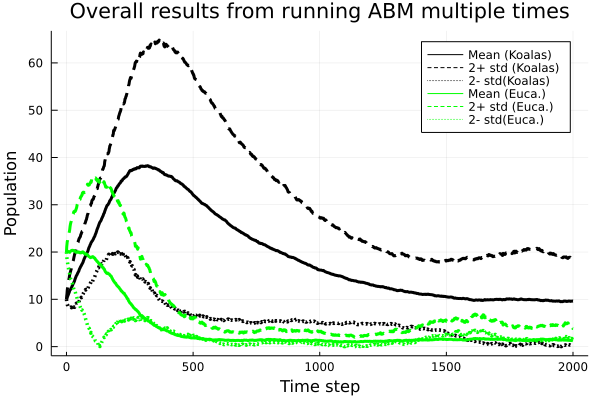

In [28]:
 # determine mean, medium and std from the overall data frames 
mean_of_50 = mean(a_koalas, dims = 2)
 median_of_50 = median(a_koalas, dims = 2)
 std_of_50 = std(a_koalas, dims = 2)

 mean_of_50_e = mean(a_euca, dims = 2)
 median_of_50_e = median(a_euca, dims = 2)
 std_of_50_e = std(a_euca, dims = 2)


 Plots.plot(adf.step, mean_of_50, label = "Mean (Koalas)", lw = 3, linecolor = :black, title = "Overall results from running ABM multiple times",xlab="Time step",ylabel="Population")
 Plots.plot!(adf.step, 2*std_of_50 + mean_of_50, label = "2+ std (Koalas)", lw = 3, linecolor = :black, linestyle = :dash )
 Plots.plot!(adf.step, abs.(mean_of_50 - 2*std_of_50) , label = "2- std(Koalas)", lw = 3.5, linecolor = :black, linestyle = :dot )

 Plots.plot!(adf.step, mean_of_50_e, label = "Mean (Euca.)", lw = 3, linecolor = :green1)
 Plots.plot!(adf.step, 2*std_of_50_e + mean_of_50_e, label = "2+ std (Euca.)", lw = 3,linecolor = :green1, linestyle = :dash)
 Plots.plot!(adf.step, abs.(mean_of_50_e - 2*std_of_50_e) , label = "2- std(Euca.)", lw = 3.5,linecolor = :green1, linestyle = :dot)



# Particle Filter
The ABM above can also be used in junction with a particle filter to estimate the parameters from real-life data. Here we try to use particle filter to determine whether the results and parameters used for the above simulation can be determined/replicated. 

## Input parameters for particle filter
The particle filter requires various inputs to accurately model the particles. The parameters required for the particle filter functions are defined as:

    μ - vector of parameters to be estimated
    var - the covariance matrix. To avoid particle collapse we   need to perturb the parameters we do this by sampling from a multivariate normal distribution. The variance for each parameter is given by Qbeta, Qc and Qgamma.
    R - observation covariance matrix
    P - number of particles (or models in this case)
    templates - initial Koala ABM models with input parameters 

In [37]:
t_koala_death_rate = 0.0025
t_eucalyptus_production_rate = 0.008
t_eucalyptus_consume_rate = 0.02

# Parameters to be estimated
μ = [t_koala_death_rate, t_eucalyptus_production_rate, t_eucalyptus_consume_rate];


Qkdr  = 0.0002 #covariance for koala_death_rate
Qepr    = 0.0005 #covariance for eucalyptus_production_rate
Qecr = 0.0002 #covariance for eucalyptus_consume_rate

# Parameter update covariance aka parameter diffusivity
var = [[Qkdr, 0.0, 0.0] [0.0,  Qepr , 0.0] [0.0,  0.0, Qecr]];

# Observation covariance
R = Matrix{Float64}(undef,1,1); 
R[1,1] = 0.1;

# Number of particles
P = 50;

#For data to be tracked
N = 10; #number of koalas
actuals = adf[:,2]; #let actuals be the current run results

#initalise the various models
ABM_params = [koala_death_rate;eucalyptus_production_rate;eucalyptus_consume_rate]
templates = [initialize_model(input_params = ABM_params) for n in 1:P]

50-element Vector{AgentBasedModel{Nothing, KoalaOrEucalyptus, typeof(Agents.Schedulers.randomly), Dict{Symbol, Float64}, MersenneTwister}}:
 AgentBasedModel with 30 agents of type KoalaOrEucalyptus
 no space
 scheduler: randomly
 properties: euca_pr, koala_dr, euca_cr
 AgentBasedModel with 30 agents of type KoalaOrEucalyptus
 no space
 scheduler: randomly
 properties: euca_pr, koala_dr, euca_cr
 AgentBasedModel with 30 agents of type KoalaOrEucalyptus
 no space
 scheduler: randomly
 properties: euca_pr, koala_dr, euca_cr
 AgentBasedModel with 30 agents of type KoalaOrEucalyptus
 no space
 scheduler: randomly
 properties: euca_pr, koala_dr, euca_cr
 AgentBasedModel with 30 agents of type KoalaOrEucalyptus
 no space
 scheduler: randomly
 properties: euca_pr, koala_dr, euca_cr
 AgentBasedModel with 30 agents of type KoalaOrEucalyptus
 no space
 scheduler: randomly
 properties: euca_pr, koala_dr, euca_cr
 AgentBasedModel with 30 agents of type KoalaOrEucalyptus
 no space
 scheduler: random

### Particle filter functions 

A number of functions are required to implement the particle filter. The first function is the resample_stratified function, which resamples the models based on their weights (which will be derived from the pf runs).

In [38]:
function resample_stratified(weights)

   N = length(weights)
   positions =  (rand(N) + collect(range(0, N - 1, length = N))) / N

   indexes = zeros(Int64, N)
   cumulative_sum = cumsum(weights)
   i, j = 1, 1
   while i <= N
       if positions[i] < cumulative_sum[j]
           indexes[i] = j
           i += 1
       else
           j += 1
       end
   end
   return indexes
end


resample_stratified (generic function with 1 method)

The next function measures the current koala population within models. This is done through accepting the model, x, as the parameter and using koala count helper function (defined above) to determine the amount of koalas.

In [39]:
function measure(x)
    num_k = koalas(x);
    return num_k;
end

measure (generic function with 1 method)

The function that initalises the particle filter (pf_init) is defined as below and accepts the following inputs:

    inits : P number of initalised SIR models
    g: function that measures the amount of infected agents
    N: Number of particles
    y: y is the actual data - specifically, this is the number of koalas for the number of steps defined when initilising the model
    R: R is the observation covariance matrix
    
This function then returns the initial end states of the models and initial log weights of the model - which are the input parameters required for the other pf functions.

In [40]:
function pf_init(inits, g, N, y, R)

    y_pf = zeros(Int64,N);
    log_w = zeros(N);

    y_pf = map(g, inits)
    log_w = map(x -> logpdf(MvNormal([y], R), x), map(x -> [x], y_pf))

    return(y_pf, log_w)

end

pf_init (generic function with 1 method)

## Particle filter function - not too sure about this section 
The pf function intakes similar parameters to the pf_init function with the addition of the following:

    log_w: the initial log weights of the models - which is one of the returned outputs from the pf_init functions. 
    N: Total population within models (or the total number of koalas in this case)

The steps conducted in this function are as follow:
1. Initialise P amount of models 
2. Scale initial log weights by the max of the log weights 
3. Resample the particles based on the weights 
4. Step the particles(models) by 1 time step
5. Record current number of infected within models
6. Calculate the predictive likelihood
7. Return the number of infected (y_pf), log weights (log_w), predictive likelihood and the particles/models

In [45]:
function pf(inits, g, log_w, N, y, R)

    wn = zeros(N);
    jnits = [initialize_model(input_params = ABM_params) for n in 1:P];
    y_pf = zeros(Int64,N);

    wn = exp.(log_w .- maximum(log_w));
    swn = sum(wn);
    wn .= wn ./ swn;

    a = resample_stratified(wn);

    for i in 1:N
        jnits[i] = deepcopy(inits[a[i]])
    end

    for i in 1:N
        Agents.step!(jnits[i], agent_step!, 1)
        y_pf[i] = g(jnits[i])
    end

    log_w = map(x -> logpdf(MvNormal([y], R), x), map(x -> [x], y_pf))

    max_weight = maximum(log_w);
    wn = exp.(log_w .- max_weight);
    swn = sum(wn);
    wn .= wn ./ swn;
    predictive_likelihood = max_weight + log(swn) - log(N);

    return(y_pf, log_w, predictive_likelihood, jnits)

end

pf (generic function with 1 method)

The runPf function is essentially a helper function used to call the pf function (above) for the data observation period (n_steps in this case), whilst also recording the mean of the observed koala population (predicted) and the log_likelihood from the pf runs. 

In [46]:
function runPf(inits, g, init_log_weights, actuals, predicted1, R)
    l         = length(actuals)
    predicted = zeros(l);
    log_w     = zeros(l, P);

    predicted[1] = predicted1;
    log_likelihood = 0;

    for i in 2:l
        (obs, new_log_weights, predictive_likelihood, news) = pf(deepcopy(inits), g, init_log_weights, P, map(x -> convert(Float64,x), actuals[i]), R);
        predicted[i] = mean(obs);
        log_likelihood = log_likelihood + predictive_likelihood;

        inits            = news;
        init_log_weights = new_log_weights;
    end
    return predicted, log_likelihood;
end

runPf (generic function with 1 method)

The particleFilter function is where the pf_init function and runPf are linked together such that the overall result of the particle filtering process is returned. Specifically, the end result is the predicted amount of koalas and the log_likelihood from the models. 

In [47]:
function particleFilter(templates, g, P, actuals, R)
    l = length(actuals);

    inits = deepcopy(templates);
    (initial_end_states, init_log_weights) = pf_init(inits, g, P, map(x -> convert(Float64,x), actuals[1]), R);

    predicted, log_likelihood = runPf(inits, g, init_log_weights, actuals, mean(initial_end_states), R);

    return predicted, log_likelihood;
end

particleFilter (generic function with 1 method)

The result of the Prior particle filter can be compared to the actual data:

In [ ]:
 @time predicted = particleFilter(templates, measure, P, actuals, R);

l = length(actuals)

Plots.plot(1:l, actuals, label="Actual", color = "red", lw = 3, title = string("Results from ", P, " particles\n"), xlab="Time",ylabel="Number", legend = :topright)
Plots.plot!(1:l, predicted, label="Tracked by Prior Particle Filter", color = "blue", lw = 3)

The following helper functions are required for the posterior particle filter. These functions are essentially used to return Multivariate samples of the parameters being tracked within the specificed variance (var - see above). 

In [49]:
function prior_sample(μ, var)
    rand(MvLogNormal(log.(μ), var))
end

function log_prior_pdf(x, μ, var)
    logpdf(MvLogNormal(log.(μ), var), x)
end

log_prior_pdf (generic function with 1 method)

In addition to the prior particle filter, a posterior particle can also be introduced. The pmh function incoporates the prior particle filter along with detered parameter values to determine both the current acceptance of the parameters and the mean of the parameter values calculated from the runs. This function accepts the following inputs:

    g: Function that measures the amount of infected agents
    P: Number of particles 
    N: Total population within models (or the total number of koalas in this case)
    K: Number of steps for the posterior particle filter 
    μ: Vector of parameters to be estimated
    var: The covariance matrix.
    actuals: The actual data from which parameters are to be estimated
    R: R is the observation covariance matrix 
    num_params: The number of parameters to be estimated 
    theta: Vector consisting of the values of parameters being estimated 

In [50]:
 function pmh(g, P, N, K, μ, var, actuals, R,num_params, theta)
     prop_acc            = zeros(K);
     log_likelihood_curr = -Inf;


     log_prior_curr = log_prior_pdf(theta[:, 1], μ, var);

     for k = 2:K
         theta_prop  = prior_sample(theta[:, k - 1], var);
         theta[:, k] = theta_prop;

         inits = [initialize_model(input_params = theta[:,k]) for n in 1:P];
         predicted, log_likelihood_prop = particleFilter(inits, g, P, actuals, R);
         log_likelihood_diff = log_likelihood_prop - log_likelihood_curr;

         log_prior_curr = log_prior_pdf(theta[:, k - 1], μ, var);
         log_prior_prop = log_prior_pdf(theta[:, k],     μ, var);
         log_prior_diff = log_prior_prop - log_prior_curr;

         acceptance_prob = exp(log_prior_diff + log_likelihood_diff);

         r = rand();
         if (r < acceptance_prob)
             log_likelihood_curr = log_likelihood_prop;
             prop_acc[k]         = 1;
         else
             theta[:, k] = theta[:, k - 1];
             prop_acc[k] = 0;
         end

         print("#####################################################################\n");
         print(" Iteration: ", k, " completed.\n");
         print(" Current state of the Markov chain: ", theta[:, k], "\n");
         print(" Proposed state of the Markov chain: ", theta_prop, "\n");
         print(" Current posterior mean: ", mean(theta[:, 1:k], dims = 2), "\n");
         print(" Current acceptance: ", mean(prop_acc[1:k]), "\n");
         print("#####################################################################\n");


     end
 end

pmh (generic function with 1 method)

To determine the result of the posterior particle filter, the following variables can be initalised and the pmh function can be called.

In [ ]:
K = 100 #Number of posterior particle filter runs 
num_params = 3; #number of parameters to be estimated
theta = zeros(num_params, K); #initalised theta or parameter vector
theta[:, 1] = prior_sample(μ, var); #detered parameters 

pmh(measure, P, N, K, μ, var, actuals, R, num_params, theta)

#####################################################################
 Iteration: 2 completed.
 Current state of the Markov chain: [0.0025012342815966884, 0.007953777751112336, 0.019339973918025825]
 Proposed state of the Markov chain: [0.0025012342815966884, 0.007953777751112336, 0.019339973918025825]
 Current posterior mean: [0.002491365464083758; 0.008119198534293718; 0.019699685736813168]
 Current acceptance: 0.5
#####################################################################
#####################################################################
 Iteration: 3 completed.
 Current state of the Markov chain: [0.0025012342815966884, 0.007953777751112336, 0.019339973918025825]
 Proposed state of the Markov chain: [0.002519889265283244, 0.007995620262885033, 0.019506458946956507]
 Current posterior mean: [0.0024946550699214017; 0.008064058273233256; 0.019579781797217387]
 Current acceptance: 0.3333333333333333
#####################################################################
###

The mean of the posterior, determined from the K number of posterior runs, can then be used to create models/particles and further calling the particle filter to determine the predicted number of infected. The result of the prior and posterior particle filter are then plotted against the actual data

In [ ]:
#This mean of the posterior was used
mean_post = [0.0024999874252689897; 0.008035042405172334; 0.019789952330170887]
# For reference, the original parameter set was [0.0025, 0.008, 0.02]


predicted_model = [initialize_model(input_params = mean_post) for n in 1:P]

@time predicted_posterior = particleFilter(predicted_model, measure, P, actuals, R);

Plots.plot(1:l, actuals, label="Actual", color = "red", lw = 3, title = string("Koala Results from ", P, " particles\n"), xlab="Time",ylabel="Number", legend = :topright,legendfontsize = 9)
Plots.plot!(1:l, predicted, label="Tracked by Prior Particle Filter", color = "blue", lw = 3)
Plots.plot!(1:l, predicted_posterior, label="Tracked by Posterior Particle Filter", color = "green", lw = 3)